In [1]:
# default_exp moe

# Merit Order Effect Analysis

<br>

### Imports

In [2]:
#exports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import FEAutils as hlp
from ipypb import track

from moepy import lowess, eda

In [3]:
%%time

df_EI = eda.load_EI_df('../data/electric_insights.csv')

df_EI.head()

Wall time: 7.79 s


,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


Text(0, 0.5, 'Price (£/MWh)')

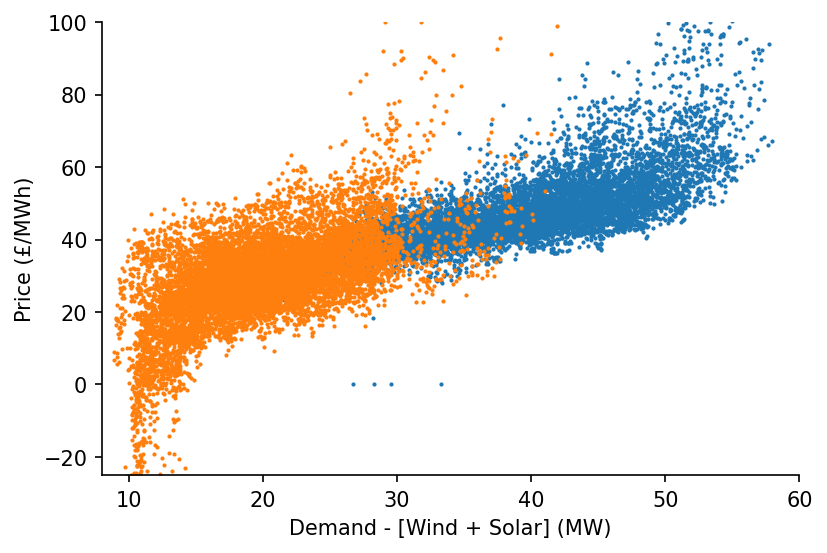

In [4]:
df_EI_model = df_EI[['day_ahead_price', 'demand', 'solar', 'wind']].dropna()

s_price = df_EI_model['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_dispatchable['2010-09':'2011-03'], s_price['2010-09':'2011-03'], s=1)
ax.scatter(s_dispatchable['2020-03':'2020-09'], s_price['2020-03':'2020-09'], s=1)

hlp.hide_spines(ax)
ax.set_xlim(8, 60)
ax.set_ylim(-25, 100)
ax.set_xlabel('Demand - [Wind + Solar] (MW)')
ax.set_ylabel('Price (£/MWh)')

In [5]:
%%time

# Fitting
reg_dates = pd.date_range('2009-01-01', '2021-01-01', freq='13W')

smooth_dates = lowess.SmoothDates()
smooth_dates.fit(s_dispatchable.values, s_price.values, dt_idx=s_dispatchable.index, 
                 reg_dates=reg_dates, frac=0.3, num_fits=31, threshold_value=26)

# Prediction
x_pred = np.linspace(8, 60, 53)

df_pred = smooth_dates.predict(x_pred=x_pred)

df_pred.head()

 [████████████████████████████████████████████████████████████] 49/49 [05:20<00:07, 6.53s/it]

c:\users\ayrto\desktop\phd\analysis\merit-order-effect\moepy\lowess.py:239: RuntimeWarning: invalid value encountered in true_divide
  loading_weights = loading_weights/loading_weights.sum(axis=0) # normalising


Wall time: 5min 23s


,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,...,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0
2009-01-04,-25.197904,-19.697833,-14.198458,-8.701850,-3.207986,2.279579,7.766803,13.257105,18.771209,24.339723,...,191.519825,199.994426,208.404577,216.829275,225.204056,233.599836,241.959057,250.321802,258.639183,267.001854
2009-04-05,-35.897568,-28.431147,-20.966206,-13.509113,-6.057171,1.382573,8.824444,16.274388,23.769274,31.357876,...,241.977105,251.959247,261.859975,271.776585,281.632207,291.513745,301.352921,311.197930,320.989457,330.837097
2009-07-05,-36.788636,-28.224829,-19.663715,-11.117691,-2.580427,5.936043,14.457608,22.993449,31.601400,40.352223,...,267.245741,277.279409,287.218735,297.170748,307.058118,316.973593,326.847585,336.730016,346.558220,356.447006
2009-10-04,-18.874849,-10.755134,-2.638993,5.457812,13.543526,21.603363,29.671536,37.762505,45.947349,54.314240,...,258.997653,267.470967,275.842164,284.218523,292.535411,300.879809,309.190859,317.513073,325.788247,334.121138
2010-01-03,10.954660,17.853995,24.749555,31.626960,38.492805,45.332537,52.179803,59.051623,66.018531,73.171976,...,244.871834,251.738222,258.495341,265.250429,271.950819,278.677803,285.379434,292.094949,298.771121,305.502093


(0.0, 400.0)

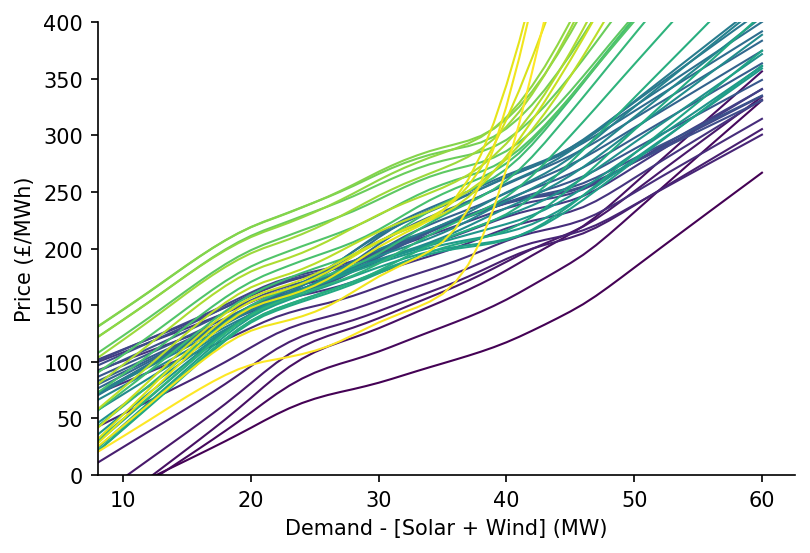

In [6]:
fig, ax = plt.subplots(dpi=150)

df_pred.T.plot(legend=False, cmap='viridis', linewidth=1, ax=ax)

hlp.hide_spines(ax)
ax.set_xlabel('Demand - [Solar + Wind] (MW)')
ax.set_ylabel('Price (£/MWh)')
ax.set_xlim(df_pred.columns[0])
ax.set_ylim(0, 400)

In [ ]:
#hide
from nbdev.export import *
notebook2script()